## Data preprocessing

In the next notebook of the series, we will perform the data preprocessing that consist of the following steps:
- drop the duplicated rows
- check the data frame in terms of missing values
- explode the measurements JSON array, sort it according to sensor serial number and limit the number of measurements
- extract the sensor, timestamp and RSSI information from array of measurements
- verify sensors' location and correct their elevation
- perform data casting and filtering
- conduct timestamps synchronization [1]
- create linear regression models of timestamp corrections
- perform the feature extraction
- calculate the normalization parameters

The notebook gives you a choice for the destination of the preprocessed data, it can be a HDF5 dataset or a MariaDB database. Both of those data stores could be used as a source of data for the machine learning model, thanks to our implementation of the dataset loaders.

For the record, our dataset comprises of three CSV files:
- round2_training1.csv
- round2_training2.csv
- round2_training3.csv

To perform the preprocessing of the entire dataset, you have to repeat all aforementioned steps for each of those files. You can do this by simply re-runing the entire notebook with the path changed in the following parts of the code:

- <code>df = spark.read.format("csv") \
    .options(header='True', inferSchema='True') \
    .load("round2_training/round2/round2_training3.csv") </code>
- <code>pd.read_csv('round2_training/round2/training3/training3.csv', dtype=types)</code>

After saving the data either by <code>df.write.save()</code> or <code>pandas.to_csv()</code> it is advised to restart the kernel in order to free up the memory.

We will begin with importing all libraries that will be used in this notebook.

In [1]:
import os
import operator
import pandas as pd
import numpy as np
import json
import urllib
import time
import pickle
import matplotlib.pyplot as plt
import findspark
findspark.init()
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import types
from pyspark.sql import SparkSession
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Now we can instantiate the <i>SparkSession</i>. For testing, the application will be running locally with 2 cores, and 4 GB of memory for the driver process. 

Other options to run <i>Spark</i> (locally, on cluster) can be found [here](http://spark.apache.org/docs/latest/submitting-applications.html#master-urls)

In [2]:
spark = SparkSession.builder \
    .master("local[2]") \
    .appName("ads-b data processing") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

We will also set the number of output partitions (low values speed up processing) and the log level for our application.

In [3]:
# Set number of output partitions
spark.conf.set("spark.sql.shuffle.partitions", 100)

# Set log level
spark.sparkContext.setLogLevel("ERROR")

Below we will load the CSV file and print its schema.

In [4]:
df = spark.read.format("csv") \
    .options(header='True', inferSchema='True') \
    .load("round2_training/round2/round2_training3.csv") 

In [5]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timeAtServer: double (nullable = true)
 |-- aircraft: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baroAltitude: double (nullable = true)
 |-- geoAltitude: double (nullable = true)
 |-- numMeasurements: integer (nullable = true)
 |-- measurements: string (nullable = true)



As we can see the shema of the data frame corresponds to the input dataset (inspected in the previous notebook).

We will also check how many rows our data frame contains.

In [6]:
print('Number of rows in the data frame: {}'.format(df.count()))

Number of rows in the data frame: 6535444


Below we will drop the duplicated rows. We will take into consideration the following columns: timeAtServer, aircraft, measurements, latitude, longitude and baroAltitude.

In [7]:
df = df.dropDuplicates(['timeAtServer', 'aircraft', 'measurements', 'latitude', 'longitude', 'baroAltitude'])

In [8]:
print('Number of rows in the data frame without duplicates: {}'.format(df.count()))

Number of rows in the data frame without duplicates: 6367870


Now we have to check whether the data frame contains any missing values.

In [9]:
df.select([F.count(F.when(F.isnan(col), col)).alias(col) for col in df.columns]).show()

+---+------------+--------+--------+---------+------------+-----------+---------------+------------+
| id|timeAtServer|aircraft|latitude|longitude|baroAltitude|geoAltitude|numMeasurements|measurements|
+---+------------+--------+--------+---------+------------+-----------+---------------+------------+
|  0|           0|       0|       0|        0|           0|          0|              0|           0|
+---+------------+--------+--------+---------+------------+-----------+---------------+------------+



According to the preceding tally, there are no missing values.

Let's take a look at how the data frame looks like.

In [10]:
df.show(10)

+----+------------------+--------+----------------+-----------------+------------+-----------+---------------+--------------------+
|  id|      timeAtServer|aircraft|        latitude|        longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|
+----+------------------+--------+----------------+-----------------+------------+-----------+---------------+--------------------+
|  94|0.0260000228881836|    2308|51.0823757365599| 6.52473449707031|     1325.88|    1264.92|              4|[[398,1005256156,...|
| 218|0.0739998817443848|     997|53.0042266845703|  5.7818603515625|     12192.0|   12092.94|              4|[[529,-1510290083...|
| 666| 0.332000017166138|    1633|45.0371246337891| 9.33380126953125|     2118.36|    2042.16|              2|[[132,1314392468,...|
| 886| 0.454999923706055|    2625|48.3951012562897| 10.2624592028166|    10988.04|    10858.5|             10|[[257,1435786406,...|
|1000| 0.519999980926514|     370| 46.047797768803| 6.03437805175781|     44

### Explode the measurements data

We have to extract the measurements data from the JSON array. To do this firstly we have to specify the shema of that array, so the <i>Spark</i> will be able to transform the data correctly. As we established in the first notebook, we take into account a limited number of measurements, thus we have to set the max_measurements to 6 (75th percentile of the distribution of the measurements).

In [11]:
df = df.limit(df.count())

In [12]:
max_measurements = 6
json_schema = types.ArrayType(types.ArrayType(types.DoubleType()))

In [13]:
df = df.withColumn('meas', F.from_json('measurements', schema=json_schema))

It would be convenient to have the measurements in some kind of order. That's why we will now sort arrays of measurements according to the sensor's serial number. To achieve this we will utilize the RDD's <i>map</i> function.

In [14]:
# Sort arrays within 'meas' column (x[9]) according to sensor number (itemgetter(0))
df = df.rdd.map(lambda x: [x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], \
                           sorted(x[9], key=operator.itemgetter(0), reverse=False)]) \
                                .toDF(df.schema.names)

In [15]:
df.select('id', 'measurements', 'meas').show(10)

+----+--------------------+--------------------+
|  id|        measurements|                meas|
+----+--------------------+--------------------+
|  94|[[398,1005256156,...|[[134.0, 1.005387...|
| 218|[[529,-1510290083...|[[170.0, 2.078536...|
| 666|[[132,1314392468,...|[[132.0, 1.314392...|
| 886|[[257,1435786406,...|[[141.0, 1.435664...|
|1000|[[131,1502574265,...|[[131.0, 1.502574...|
|1018|[[216,1465412046,...|[[184.0, 4.861520...|
|1027|[[694,84457592500...|[[26.0, 2.0826087...|
|1079|[[185,811651796,5...|[[184.0, 4.916273...|
|1187|[[564,1571338843,...|[[513.0, 8.271332...|
|1248|[[259,1643958296,...|[[10.0, 1.6436849...|
+----+--------------------+--------------------+
only showing top 10 rows



We will explode the 'meas' field so that the sensor, timestamp and RSSI information of each measurement is presented as a separate column, at the same time we will cast new fields to the proper data type.

In [16]:
col_names = ['sensor', 'tmp', 'RSSI']
col_types = ['int', 'Decimal(16,0)', 'int']

for i in range(max_measurements):
    for j, col_name in enumerate(col_names): 
        df = df.withColumn('{}_{}'.format(col_name, i), F.col('meas')[i][j].cast(col_types[j]))

df = df.drop('meas', 'measurements') 

In [17]:
df.select('id', 'sensor_0', 'tmp_0', 'RSSI_0', 'sensor_1', 'tmp_1', 'RSSI_1').show(10, False)

+----+--------+-----------+------+--------+-----------+------+
|id  |sensor_0|tmp_0      |RSSI_0|sensor_1|tmp_1      |RSSI_1|
+----+--------+-----------+------+--------+-----------+------+
|94  |134     |1005387312 |107   |248     |-268722583 |105   |
|218 |170     |20785362500|186   |507     |57626342333|20    |
|666 |132     |1314392468 |83    |277     |60809942500|59    |
|886 |141     |1435664828 |115   |143     |1435638218 |115   |
|1000|131     |1502574265 |73    |665     |44191180417|84    |
|1018|184     |4861520250 |184   |216     |1465412046 |39    |
|1027|26      |20826087583|132   |236     |21155851500|11    |
|1079|184     |4916273917 |98    |185     |811651796  |50    |
|1187|513     |82713328667|101   |564     |1571338843 |51    |
|1248|10      |1643684906 |119   |14      |1643671093 |101   |
+----+--------+-----------+------+--------+-----------+------+
only showing top 10 rows



Now we will save the transformed data frame into a disk.

In [18]:
df.write.save('round2_training/round2/training3', format='csv', header=True, mode='overwrite')

In [19]:
file_name = [name for name in os.listdir('round2_training/round2/training3') if name.startswith('part')]

os.rename(os.path.join('round2_training/round2/training3', file_name[0]),
          'round2_training/round2/training3/training3.csv')

### Sensor localizations

In this section, we will verify the localization of the sensors. We do not have enough data to check whether the receiver's location is not very accurate. What we can do is to find incorrect coordinates like for instance (0, 0, 0).

In [26]:
sensor_data = pd.read_csv("round2_training/round2/round2_sensors.csv")
sensor_data.loc[(sensor_data.latitude == 0) | (sensor_data.longitude == 0) | (sensor_data.height == 0)]

,serial,latitude,longitude,height,type,good
2,3,0.000000,0.000000,0.0,SBS-3,False
4,5,52.356455,4.952216,0.0,dump1090,False
5,6,47.174200,8.524700,0.0,Radarcape,False
8,9,45.410944,11.887529,0.0,Radarcape,False
26,27,49.408540,6.950260,0.0,SBS-3,False
77,78,33.573110,-7.589843,0.0,dump1090,False
78,79,34.018125,-5.007845,0.0,dump1090,False
144,145,0.000000,0.000000,0.0,dump1090,False
228,229,52.450600,5.500400,0.0,dump1090,False
333,334,0.000000,0.000000,0.0,dump1090,False


As we can see there are some coordinates with all zero values indicating that those locations haven't been specified, but also we can see that for some latitude/longitude coordinates the value of the height (elevation) equals zero, this requires to manually check and amend those elevations. To achieve this we will utilize the <i>Opentopodata</i> Public API.

In [27]:
def getElevation(lat, lon):
    """Returns the elevation (m) for provided latitude and longitude coordinates. Returns 0 if elevation hasn't been found.
    
    """

    coords = '{},{}'.format(lat, lon)

    url = "https://api.opentopodata.org/v1/etopo1?locations=" + urllib.parse.quote(coords)

    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0 (X11; Linux x86_64; rv:69.0) Gecko/20100101 Firefox/69.0')]
    urllib.request.install_opener(opener)

    response = urllib.request.urlopen(url)
    data = response.read()
    encoding = response.info().get_content_charset('utf-8')
    
    time.sleep(3)

    data = json.loads(data.decode(encoding))
    
    try:
        return data['results'][0]['elevation']
    except:
        return 0

Now we will use the <i>getElevation</i> function to populate the data frame with new elevations.

In [28]:
for i, row in sensor_data.loc[(sensor_data.latitude != 0) & (sensor_data.longitude != 0) \
                           & (sensor_data.height == 0)].iterrows():

    sensor_data.loc[i, 'height'] = getElevation(row.latitude, row.longitude)

That operation is successful. Only one data point has been left with unspecified elevation.

In [29]:
sensor_data.loc[(sensor_data.latitude != 0) & (sensor_data.longitude != 0)   & (sensor_data.height == 0)]

,serial,latitude,longitude,height,type,good
381,382,56.0333,14.1333,0.0,dump1090,False


Now we have to determine the number of times given sensor without coordinates occurred in the flights' dataset.

In [30]:
sensor_data.loc[(sensor_data.latitude == 0) & (sensor_data.longitude == 0)]

,serial,latitude,longitude,height,type,good
2,3,0.0,0.0,0.0,SBS-3,False
144,145,0.0,0.0,0.0,dump1090,False
333,334,0.0,0.0,0.0,dump1090,False
334,335,0.0,0.0,0.0,dump1090,False
336,337,0.0,0.0,0.0,dump1090,False
702,703,0.0,0.0,0.0,dump1090,False


Firstly we need to load the flights data frame.

In [31]:
flights = pd.read_csv('round2_training/round2/training3/trainig3.csv')

Subsequently, the frequency of sensors without coordinates can be established.

In [32]:
max_measurements = 10
count_dict = {}

for i, row in sensor_data.loc[(sensor_data.latitude == 0) & (sensor_data.longitude == 0)].iterrows():
    count = 0
    for sensor_nu in range(max_measurements):
        count += flights.loc[flights['{}_sensor'.format(sensor_nu)] == row.serial, '{}_sensor'.format(sensor_nu)].count()
    count_dict[row.serial] = count

In [33]:
pd.DataFrame({'count': count_dict})

,count
3,0
145,0
334,0
335,0
337,0
703,0


In each of our flights' datasets, neither of the sensors without localization information is included, thus we do not have to perform any further filtering of sensors in the dataset.

In [34]:
sensor_data.to_csv('round2_training/round2/round2_sensors.csv', index=False)

### Data casting and filtering

Next, we will cast the data to proper data types and filter-out data with incorrect timestamps.

In [3]:
flights = pd.read_csv('round2_training/round2/training3/training3.csv')

max_measurements = 6

In [4]:
# Change column data types
types = {'id': 'int32', 'timeAtServer': 'float32', 'aircraft': 'int16', 'latitude': 'float32', 'longitude': 'float32',
        'baroAltitude': 'float32', 'geoAltitude': 'float32', 'numMeasurements': 'int16'}

for i in range(max_measurements):
    types['tmp_{}'.format(i)] = 'float64'
    types['RSSI_{}'.format(i)] = 'int16'
    
# Fill missing values for RSSI fields
flights.fillna(value={i:0 for i in list(types.keys()) if i.startswith('RSSI')}, inplace=True)

flights = flights.astype(types, errors='ignore')

There are some negative values for the timestamp of sensor_0, thus to be able to use this sensor as a reference clock during the synchronization process we have to take absolute values of those timestamps.

In [5]:
flights['tmp_0'] = flights['tmp_0'].abs()

Now we will drop all the rows that contain 0 values in timestamp columns.

In [6]:
idx = []

for i in range(max_measurements):
    idx.extend(flights.loc[flights['tmp_{}'.format(i)] == 0].index)
        
flights.drop(idx, inplace=True)

In [7]:
flights.to_csv('round2_training/round2/training3/training3.csv', index=False)

### Timestamp synchronization

In the dataset, only some receivers will provide GPS-synchronized timestamps while others do not offer such time synchronization and thus experience clock drifts. We have to perform timestamp synchronization in order to ensure that all timestamps are measured according to the same reference clock.

The method of timestamp synchronization is depicted in the following diagram and is based on the paper - <i> The Testing of MLAT Method Application by means of Usage low-cost ADS-B Receivers</i> [1]. According to that method, the ADS-B message with airplane position pA is received by ground station p1 and p2 in time t1 and t2 respectively. Knowing the distance between airplane and first sensor |pA-p1| and between airplane and second sensor |pA-p2| we are able to calculate the signal reception time at receiver p2 (t2_corr) with respect to sensor's p1 clock. By subtracting t2_corr from the original time of reception (t2) we can determine the correction that needs to be applied to each message at sensor p2 [1]. Because the correction value tend to change in time, we will also create the linear regression models of sensor corrections that represent the relationship between the correction that has to be applied and the timeAtServer.

<img src="assets/clock_synch_method.png" width="500 px">
<p><center>Receiver’s clock synchronization method [1]</center></p>

In [2]:
max_measurements = 6

types = {'id': 'int32', 'timeAtServer': 'float32', 'aircraft': 'int16', 'latitude': 'float32', 'longitude': 'float32',
        'baroAltitude': 'float32', 'geoAltitude': 'float32', 'numMeasurements': 'int16'}

for i in range(max_measurements):
    types['tmp_{}'.format(i)] = 'float64'
    types['RSSI_{}'.format(i)] = 'int16'

To speed up the timestamp synchronization calculations we will use the <i>Modin</i> library, whose implementation enables you to use all of the cores on your machine, or in a cluster.

In [3]:
from distributed import Client

# set up cluster and workers
client = Client(n_workers=2, 
                threads_per_worker=1,
                memory_limit='5GB')

import modin.pandas as pd

We will begin by loading the flights' dataset and the sensors' dataset.

In [4]:
flights = pd.read_csv('round2_training/round2/training3/training3.csv', dtype=types)

In [5]:
sensors = pd.read_csv('round2_training/round2/round2_sensors.csv')

Below we will define functions for converting WSG84 coordinates to cartesian ones, and for calculating the Euclidean distance between coordinates.

In [6]:
def lla_to_ecef(latitude, longitude, altitude):
    latitude = np.radians(latitude)
    longitude = np.radians(longitude)

    # WSG84 ellipsoid constants
    a = 6378137
    e = 8.1819190842622e-2

    # prime vertical radius of curvature
    N = a / np.sqrt(1 - e**2 * np.sin(latitude)**2)

    x = (N + altitude) * np.cos(latitude) * np.cos(longitude)
    y = (N + altitude) * np.cos(latitude) * np.sin(longitude)
    z = ((1 - e**2) * N + altitude) * np.sin(latitude)
    
    return x, y, z

def calculateDist(x1, y1, z1, x2, y2, z2):  
    x1, y1, z1 = lla_to_ecef(x1, y1, z1)
    x2, y2, z2 = lla_to_ecef(x2, y2, z2)
    
    return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) / 1000

Before joining flights' and sensors' dataframes together, we have to set the index of the sensors' dataframe to 'serial'.

In [7]:
sensors.set_index('serial', inplace=True)

In [8]:
sensors.head()

,latitude,longitude,height,type,good
serial,,,,,
1,46.681067,7.665313,680.9232,SBS-3,False
2,40.337042,-3.770206,735.7872,SBS-3,False
3,0.000000,0.000000,0.0000,SBS-3,False
4,47.143056,7.243889,550.1640,SBS-3,False
5,52.356455,4.952216,-1.0000,dump1090,False


In [9]:
flights.head()

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,sensor_0,tmp_0,...,RSSI_2,sensor_3,tmp_3,RSSI_3,sensor_4,tmp_4,RSSI_4,sensor_5,tmp_5,RSSI_5
0,94,0.026,2308,51.082375,6.524734,1325.880005,1264.920044,4,134,1.005387e+09,...,170,670.0,1.005362e+09,62,NaN,NaN,0,NaN,NaN,0
1,218,0.074,997,53.004227,5.781860,12192.000000,12092.940430,4,170,2.078536e+10,...,19,704.0,7.726590e+10,10,NaN,NaN,0,NaN,NaN,0
2,666,0.332,1633,45.037125,9.333801,2118.360107,2042.160034,2,132,1.314392e+09,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
3,886,0.455,2625,48.395100,10.262459,10988.040039,10858.500000,10,141,1.435665e+09,...,148,257.0,1.435786e+09,55,263.0,1.435661e+09,67,388.0,7.471172e+10,23
4,1000,0.520,370,46.047798,6.034378,4480.560059,4381.500000,2,131,1.502574e+09,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0


Now we will join the aforementioned dataframes, so that we will have all the sensors coordinates together with the flights' data.

In [10]:
for i in range(max_measurements):
    flights = flights.join(sensors.loc[:, ['latitude', 'longitude', 'height']], on='sensor_{}'.format(i),
                           rsuffix='_{}'.format(i))
    
flights.rename({'height': 'height_0'}, axis=1, inplace=True)

In [11]:
types_coords = {}

for i in range(max_measurements):
    types_coords['latitude_{}'.format(i)] = 'float32'
    types_coords['longitude_{}'.format(i)] = 'float32'
    types_coords['height_{}'.format(i)] = 'float32'
    
flights = flights.astype(types_coords, errors='ignore')

In [13]:
flights.loc[:10, ['sensor_0', 'sensor_1', 'tmp_0', 'tmp_1', 'latitude_0', 'longitude_0', 'latitude_1', 'longitude_1']]

,sensor_0,sensor_1,tmp_0,tmp_1,latitude_0,longitude_0,latitude_1,longitude_1
0,134,248,1.005387e+09,-2.687226e+08,50.937080,7.353797,51.228470,6.679641
1,170,507,2.078536e+10,5.762634e+10,52.532749,7.309251,53.062771,6.076188
2,132,277,1.314392e+09,6.080994e+10,45.556053,10.225396,45.976501,8.945900
3,141,143,1.435665e+09,1.435638e+09,47.511948,10.280076,48.365822,11.478391
4,131,665,1.502574e+09,4.419118e+10,46.479492,6.837746,45.741699,4.821200
5,184,216,4.861520e+09,1.465412e+09,52.990002,-0.411000,51.872524,-0.506857
6,26,236,2.082609e+10,2.115585e+10,48.996437,14.392090,51.062847,13.674202
7,184,185,4.916274e+09,8.116518e+08,52.990002,-0.411000,51.759014,-1.256688
8,513,564,8.271333e+10,1.571339e+09,39.276299,-7.590500,39.231777,-9.308084
9,10,14,1.643685e+09,1.643671e+09,47.400169,8.630680,47.248295,8.529757


The following code performs the timestamp synchronization and calculates the corrections. 

In [13]:
for i in tqdm(range(1, max_measurements)):
    dist_aircraft_t1 = flights.apply(lambda x: calculateDist(x['latitude'], x['longitude'], x['geoAltitude'], \
                                                                x['latitude_0'.format(i)], 
                                                                x['longitude_0'.format(i)], 
                                                                x['height_0'.format(i)],), axis=1)
    
    dist_aircraft_t2 = flights.apply(lambda x: calculateDist(x['latitude'], x['longitude'], x['geoAltitude'], \
                                                                x['latitude_{}'.format(i)], 
                                                                x['longitude_{}'.format(i)], 
                                                                x['height_{}'.format(i)],), axis=1)
    
    # Time of message reception at t2 receiver according to t1 clock (ns)
    t2_corr = flights.tmp_0 - (dist_aircraft_t1[0]/29979e-8) + (dist_aircraft_t2[0]/29979e-8) 
    
    # Correction applied to each time message reception at t2 receiver (ns)
    correction = flights['tmp_{}'.format(i)] - t2_corr
    
    flights['tmp_{}'.format(i)] = t2_corr
    
    flights['corr_{}'.format(i)] = correction


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [38:49<00:00, 465.85s/it]


Below we will plot calculated corrections for chosen sensor pairs. We will also fit the linear regression line into the data to depict how well this method represents the relationship between correction and timeAtServer for each sensor pair.

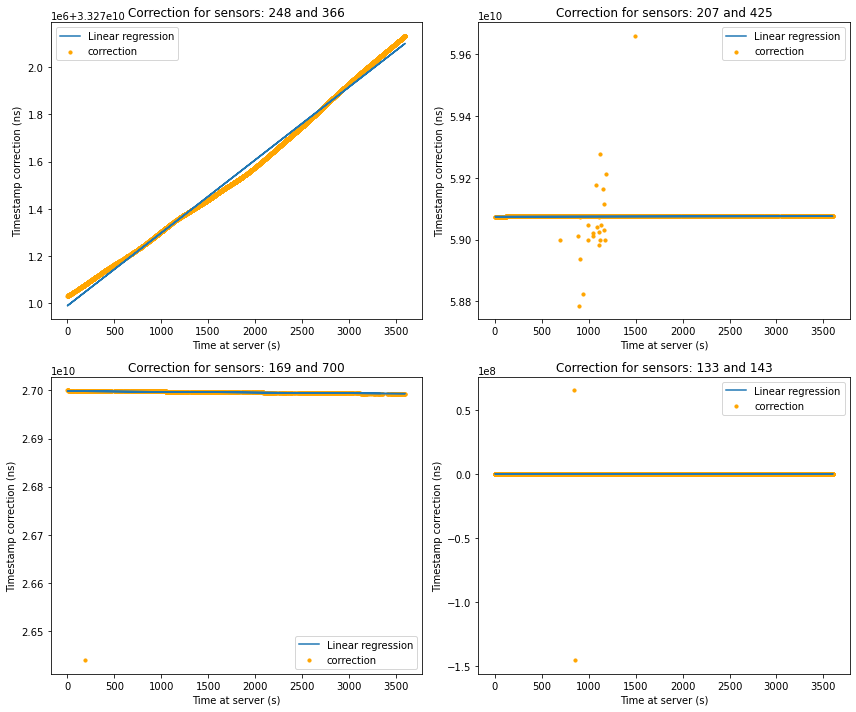

In [14]:
sensor_pairs = [(248, 366), (207, 425), (169, 700), (133, 143)]

fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=False)
count = 0

for row in range(2):
    for col in range(2):
        s1, s2 = sensor_pairs[count]
        xy = flights.loc[(flights.sensor_0 == s1) & (flights.sensor_1 == s2), ['timeAtServer', 'corr_1']].values

        m, b = np.polyfit(xy[:, 0], xy[:, 1], 1)

        axes[row, col].scatter(xy[:, 0], xy[:, 1], s=10, c='orange', label='correction')
        axes[row, col].plot(xy[:, 0], m * xy[:, 0] + b, label='Linear regression')
        axes[row, col].set_title('Correction for sensors: {} and {}'.format(s1, s2))
        axes[row, col].set_ylabel('Timestamp correction (ns)')
        axes[row, col].set_xlabel('Time at server (s)')
        axes[row, col].legend()
        
        count += 1
        
plt.tight_layout()

As we can see there are some outliers on the preceding plots, but in general, the linear regression line fits the correction data very well, thus it can be used to estimate the correction that has to be applied to each timestamp measurement.

We will implement a custom function responsible for writing the dataframe into CSV file in the bach manner.

In [14]:
def pandas_to_csv(df, path, n_chunks=10, chunk_size=None, index=False):
    
    df_len = len(df)
    
    if chunk_size:
        n_chunks = df_len // chunk_size
        
    if df_len % (n_chunks) != 0:
        chunk_idxs = list(range(0, df_len, df_len//n_chunks)) 
    else:
        chunk_idxs = list(range(0, df_len+1, df_len//n_chunks))
        
    chunk_idxs[-1] = df_len
    
    header = True
    mode = 'w'
    
    for start, end in zip(chunk_idxs[:-1], chunk_idxs[1:]):
        chunk = df.iloc[start:end]
        chunk.to_csv(path, index=index, header=header, mode=mode)
        
        del chunk
        
        header = False
        mode = 'a'


In [15]:
pandas_to_csv(flights, 'round2_training/round2/training3/training3.csv', n_chunks=5, index=False)

### Linear regression models of sensor corrections

In this section, we are going to fit the linear regression models into timestamp correction data of all sensors. There will be a single model for each pair of sensors (reference sensor + sensor_N), that given the current timeAtServer returns the correction value that needs to be applied.

We have to begin by loading the synchronized data.

In [2]:
max_measurements = 6

usecols = ['timeAtServer'] + ['sensor_{}'.format(i) for i in range(max_measurements)] + \
    ['corr_{}'.format(i) for i in range(1, max_measurements)]

flights = pd.read_csv('round2_training/round2/training3/training3.csv', usecols=usecols)

Now we will create the dictionary that contains all sensors that make a pair with the reference sensor. The dictionary will also include their corresponding correction and timeAtServer values.

In [3]:
corr_dict = {}

for row in tqdm(flights.itertuples(), total=len(flights)):

    s1 = row.sensor_0
    timeAtServer = row.timeAtServer
    
    for i in range(1, max_measurements):
        s2 = getattr(row, 'sensor_{}'.format(i))
        corr = getattr(row, 'corr_{}'.format(i))
        
        if np.isnan(s2):
            continue
            
        s1, s2 = int(s1), int(s2)
        corr_dict.setdefault('{}_{}'.format(s1, s2), {'TaS': [], 'corr': []})
        corr_dict['{}_{}'.format(s1, s2)]['TaS'].append(timeAtServer)
        corr_dict['{}_{}'.format(s1, s2)]['corr'].append(corr)


100%|█████████████████████████████████████████████████████████████████████| 6166940/6166940 [02:10<00:00, 47240.92it/s]


Below we will fit the linear regression models one by one and save their coefficients into a dictionary.

In [4]:
coeff_dict = {}

for sensors in list(corr_dict.keys()):
    x = np.array(corr_dict[sensors]['TaS'])
    y = np.array(corr_dict[sensors]['corr'])
    m, b = np.polyfit(x, y, 1)
    
    coeff_dict[sensors] = (m, b)

At last, we will persist the coefficients dictionary on a disk for further use.

In [5]:
if os.path.exists('coeff_dict.pickle'):
    with open(r"coeff_dict.pickle", "rb") as output_file:
        coeff_dict_read = pickle.load(output_file)
        coeff_dict.update(coeff_dict_read)

In [6]:
with open(r"coeff_dict.pickle", "wb") as output_file:
    pickle.dump(coeff_dict, output_file)

### Feature extraction and filtering

In this section we are going to focus on extracting the following additional features:
- timestamp differences
- the mean latitude and longitude location of the receivers
- the weighted mean of sensors coordinates

At first, we will instantiate the <i>SparkSession</i> and set the number of output partitions and the log level.

In [2]:
spark = SparkSession.builder \
    .master("local[2]") \
    .appName("ads-b data processing") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [3]:
# Set number of output partitions
spark.conf.set("spark.sql.shuffle.partitions", 100)

# Set log level
spark.sparkContext.setLogLevel("ERROR")

In [4]:
df = spark.read.format("csv") \
    .options(header='True', inferSchema='True') \
    .load('round2_training/round2/training3/training3.csv') 

Next, we will remove the columns that are no longer useful.

In [5]:
max_measurements = 6

# Select columns to drop. We will keep timeAtServer and aircraft fields for visualization purposes
cols = ['id', 'numMeasurements'] + ['sensor_{}'.format(i) for i in range(max_measurements)] \
    + ['corr_{}'.format(i) for i in range(1, max_measurements)]

In [6]:
df = df.drop(*cols)

Below we will calculate the timestamp differences that are going to be used as additional features.

In [7]:
# Specify the number of measurements to be taken into account while calculating differences
n_meas_diff = 4

for col_1 in range(1, n_meas_diff):
    for col_2 in range(col_1):
        df = df.withColumn('diff_{}_{}'.format(col_1, col_2), F.col('tmp_{}'.format(col_1)) - \
                           F.col('tmp_{}'.format(col_2)))

In [8]:
df.select('tmp_0', 'tmp_1', 'tmp_2', 'diff_1_0', 'diff_2_0').show(5)

+---------------+--------------------+--------------------+-------------------+-------------------+
|          tmp_0|               tmp_1|               tmp_2|           diff_1_0|           diff_2_0|
+---------------+--------------------+--------------------+-------------------+-------------------+
|  6.040732833E9| 6.040755583653483E9|6.0415790803354225E9| 22750.653483390808|  846247.3354225159|
|  4.181512167E9|4.1815121993956394E9|4.1816904042636733E9| 32.395639419555664|  178237.2636733055|
|6.8231743833E10| 6.82318009082791E10|                null|  57075.27909851074|               null|
|4.4342689333E10|4.434263257770246E10|4.434262728769303E10|-56755.297538757324|-62045.306968688965|
|   3.06961578E8| 3.067029259464967E8|3.0658706102887994E8|-258652.05350327492| -374516.9711200595|
+---------------+--------------------+--------------------+-------------------+-------------------+
only showing top 5 rows



The next feature to extract is the mean latitude and longitude location of the sensors receiving the signal.

In [9]:
cols = [col for col in df.columns if 'latitude_' in col]

df = df.withColumn('mean_lat',\
     sum([F.when(F.col(col).isNull(), 0).otherwise(F.col(col)) for col in cols])/ \
     sum([F.when(F.col(col).isNull(), 0).otherwise(1) for col in cols])). \
     fillna(0, 'mean_lat')

cols = [col for col in df.columns if 'longitude_' in col]

df = df.withColumn('mean_lon',\
     sum([F.when(F.col(col).isNull(), 0).otherwise(F.col(col)) for col in cols])/ \
     sum([F.when(F.col(col).isNull(), 0).otherwise(1) for col in cols])). \
     fillna(0, 'mean_lon')

In [10]:
df.select('latitude_0', 'latitude_1', 'latitude_2', 'latitude_3', 'mean_lat').show(5)

+----------+----------+----------+----------+------------------+
|latitude_0|latitude_1|latitude_2|latitude_3|          mean_lat|
+----------+----------+----------+----------+------------------+
|   49.9943|    50.123|   48.0281|      null|           49.3818|
|   49.5692| 49.569286| 46.762405|      null|48.633630333333336|
|   53.0433| 53.571148|      null|      null|53.307224000000005|
|   52.2627| 52.436016|   52.1114|  52.38154|         52.297914|
| 51.759014|   53.0433| 52.780922|   53.3575|52.574139333333335|
+----------+----------+----------+----------+------------------+
only showing top 5 rows



In [11]:
df.select('longitude_0', 'longitude_1', 'longitude_2', 'longitude_3', 'mean_lon').show(5)

+-----------+-----------+-----------+-----------+-------------------+
|longitude_0|longitude_1|longitude_2|longitude_3|           mean_lon|
+-----------+-----------+-----------+-----------+-------------------+
|     8.6604|    8.69833|    10.7168|       null|            9.35851|
|      6.064|   6.064015|   7.600447|       null|           6.576154|
|    -2.2295|  -3.059619|       null|       null|-2.6445594999999997|
|  13.619793|  13.361244|    11.6383|    9.98306|        12.15059925|
|  -1.256688|    -2.2295|   -1.20459|    -1.4963|-1.4577513333333334|
+-----------+-----------+-----------+-----------+-------------------+
only showing top 5 rows



We will also use the weighted mean of sensors coordinates as an additional feature. In this calculation, weights are going to be inverse values of timestamp measurements.

In [12]:
cols = [col for col in df.columns if 'latitude_' in col]

df = df.withColumn('w_mean_lat',\
     sum([F.when(F.col(col).isNull(), 0).otherwise(F.col(col)*(1/F.col('tmp_{}'.format(i)))) \
          for i, col in enumerate(cols)])/ \
     sum([F.when(F.col(col).isNull(), 0).otherwise(1/F.col('tmp_{}'.format(i))) \
          for i, col in enumerate(cols)])). \
     fillna(0, 'w_mean_lat')

cols = [col for col in df.columns if 'longitude_' in col]

df = df.withColumn('w_mean_lon',\
     sum([F.when(F.col(col).isNull(), 0).otherwise(F.col(col)*(1/F.col('tmp_{}'.format(i)))) \
          for i, col in enumerate(cols)])/ \
     sum([F.when(F.col(col).isNull(), 0).otherwise(1/F.col('tmp_{}'.format(i))) \
          for i, col in enumerate(cols)])). \
     fillna(0, 'w_mean_lon')

In [13]:
df.select('latitude_0', 'latitude_1', 'tmp_0', 'tmp_1', 'w_mean_lat').show(5)

+----------+----------+---------------+--------------------+------------------+
|latitude_0|latitude_1|          tmp_0|               tmp_1|        w_mean_lat|
+----------+----------+---------------+--------------------+------------------+
|   49.9943|    50.123|  6.040732833E9| 6.040755583653483E9| 49.38186227698855|
|   49.5692| 49.569286|  4.181512167E9|4.1815121993956394E9|48.633656917200746|
|   53.0433| 53.571148|6.8231743833E10| 6.82318009082791E10|53.307223889614946|
|   52.2627| 52.436016|4.4342689333E10|4.434263257770246E10| 52.29791384004996|
| 51.759014|   53.0433|   3.06961578E8| 3.067029259464967E8| 52.57458086608702|
+----------+----------+---------------+--------------------+------------------+
only showing top 5 rows



In [14]:
df.select('longitude_0', 'longitude_1', 'tmp_0', 'tmp_1', 'w_mean_lon').show(5)

+-----------+-----------+---------------+--------------------+-------------------+
|longitude_0|longitude_1|          tmp_0|               tmp_1|         w_mean_lon|
+-----------+-----------+---------------+--------------------+-------------------+
|     8.6604|    8.69833|  6.040732833E9| 6.040755583653483E9|  9.358447406976023|
|      6.064|   6.064015|  4.181512167E9|4.1815121993956394E9|  6.576139448214619|
|    -2.2295|  -3.059619|6.8231743833E10| 6.82318009082791E10| -2.644559326403184|
|  13.619793|  13.361244|4.4342689333E10|4.434263257770246E10| 12.150603058294632|
|  -1.256688|    -2.2295|   3.06961578E8| 3.067029259464967E8|-1.4574936088578214|
+-----------+-----------+---------------+--------------------+-------------------+
only showing top 5 rows



As the last step, we will fill in missing values and save the data frame.

In [15]:
df = df \
    .fillna(-90, subset=[col for col in df.columns if 'latitude' in col]) \
    .fillna(-180, subset=[col for col in df.columns if 'longitude' in col]) \
    .fillna(-90, subset=[col for col in df.columns if 'mean_lat' in col]) \
    .fillna(-180, subset=[col for col in df.columns if 'mean_lon' in col]) \
    .fillna(0)

In [16]:
df.repartition(1).write.save('round2_training/round2/tmp_training3/', format='csv', header=True)

In [17]:
list_dir = os.listdir('round2_training/round2/tmp_training3/')

if '_SUCCESS' in list_dir:
    file_name = [name for name in list_dir if name.startswith('part')]
    os.rename(os.path.join('round2_training/round2/tmp_training3', file_name[0]), \
              'round2_training/round2/tmp_training3/training3.csv')
    os.replace('round2_training/round2/tmp_training3/training3.csv', 'round2_training/round2/training3/training3.csv')
    
    import shutil
    shutil.rmtree('round2_training/round2/tmp_training3/')

### Normalization parameters

In this section, we are going to calculate the normalization parameters - minimum and maximum, that subsequently can be used by machine learning models to normalize the input batches of data.

First, we have to load the data.

In [2]:
df_csv = pd.read_csv('round2_training/round2/training3/training3.csv', nrows=1)

columns = list(df_csv.columns)

use_cols = [col for col in columns if ('latitude' not in col) and ('longitude' not in col) and \
           ('mean' not in col)]

In [3]:
flights = pd.read_csv('round2_training/round2/training3/training3.csv', usecols=use_cols)

Now we will calculate the normalization parameters (MIN, MAX) for each feature.

In [4]:
norm_params = {}

for col in columns:
    if ('latitude' in col) or ('mean_lat' in col):
        norm_params[col] = {'min': -90, 'max': 90}
    elif ('longitude' in col) or ('mean_lon' in col):
        norm_params[col] = {'min': -180, 'max': 180}
    elif ('timeAtServer' in col) or ('aircraft' in col):
        pass
    else:
        norm_params[col] = {'min': flights[col].min(), 'max': flights[col].max()}


The following code will update the normalization parameters if the notebook is restarted.

In [5]:
if os.path.exists('norm_params.pickle'):
    with open(r"norm_params.pickle", "rb") as output_file:
        norm_params_read = pickle.load(output_file)
        
    # Update normalization parameters
    for k, v in norm_params_read.items():
        if k == 'input_features':
            norm_params[k] = norm_params_read[k]
        elif k == 'target':
            norm_params[k] = norm_params_read[k]
        elif v['max'] > norm_params[k]['max']:
            norm_params[k]['max'] = v['max']
        elif v['min'] < norm_params[k]['min']:
            norm_params[k]['min'] = v['min']
            

In [6]:
target_cols = ['latitude', 'longitude', 'geoAltitude']
vis_cols = ['timeAtServer', 'aircraft']
input_feature = [col for col in columns if (col not in target_cols) and (col not in vis_cols)]

norm_params['input_features'] = input_feature
norm_params['target'] = target_cols

Now we will save the dictionary with the normalization parameters as a <i>pickle</i> file.

In [8]:
with open(r"norm_params.pickle", "wb") as output_file:
    pickle.dump(norm_params, output_file)

### Create the HDF5 training dataset

The rest of the code in this notebook should be run last after the entire training dataset (all three files) has been preprocessed. 

We will write the content of the CSV training dataset into to HDF5 file.

In [2]:
import pandas as pd
import pickle
import numpy as np

After importing the libraries we have to specify the paths of all preprocessed files and the name of the HDF5 file.

In [3]:
train_path_1 = 'round2_training/round2/training1/training1.csv'
train_path_2 = 'round2_training/round2/training2/training2.csv'
train_path_3 = 'round2_training/round2/training3/training3.csv'

files = [train_path_1, train_path_2, train_path_3]

hdf5_path = 'training.hdf5'

In [4]:
with open(r"norm_params.pickle", "rb") as output_file:
    norm_params = pickle.load(output_file)

In [5]:
input_feature = norm_params['input_features']
target_cols = norm_params['target']

The following code will create the HDF5 file.

In [8]:
with pd.HDFStore(hdf5_path, 'w') as store:
    for file in files:
        try:
            df = pd.read_csv(file, encoding='utf-8', chunksize=500000, index_col=False)
            
            try:
                nrows = store.get_storer('input').nrows
            except:
                nrows = 0
            
            for chunk in df:
                chunk.index = pd.Series(chunk.index) + nrows
                store.append('input', chunk.loc[:, input_feature].astype('float'))
                store.append('target', chunk.loc[:, target_cols].astype('float'))

        except Exception as detail:
            print(file, detail)


### Populate MariaDB database

Before we insert the data into MariaDB database we have to first create one. Use the <i>createDB.py</i> python script to create MariaDB database.

In [1]:
import pandas as pd
import mariadb
import pickle
import logging
import sys
from getpass import getpass
from config import mariadb_hostname, mariadb_port, mariadb_database_name, mariadb_table_name

In [2]:
train_path_1 = 'round2_training/round2/training1/training1.csv'
train_path_2 = 'round2_training/round2/training2/training2.csv'
train_path_3 = 'round2_training/round2/training3/training3.csv'

files = [train_path_1, train_path_2, train_path_3]

Use the login and the password you provided during the initialization of the MariaDB.

In [3]:
print('Login to MariaDB:')
mariadb_user = input('User: ')
mariadb_password = getpass('Password: ')

# For Docker - uncomment the following line to override the mariadb_hostname
# mariadb_hostname = 'mariadb' 

# Connect to MariaDB server
try:
    cnx = mariadb.connect(host=mariadb_hostname, port=mariadb_port, user=mariadb_user, password=mariadb_password)
except mariadb.Error as msg:
    logging.error("Error connecting to MariaDB Platform: {}".format(msg))
    sys.exit(1)

Login to MariaDB:
User: root
Password: ········


Now we will insert all the data into MariaDB database.

In [4]:
with open(r"norm_params.pickle", "rb") as output_file:
    norm_params = pickle.load(output_file)
    
columns = ['timeAtServer', 'aircraft'] + norm_params['input_features'] + norm_params['target']

# Instantiate cursor object
cursor = cnx.cursor()

# Use given database
cursor.execute("USE {};".format(mariadb_database_name))

insert_query = "INSERT INTO " + mariadb_table_name + " (" + ", ".join(columns) + ") VALUES (" + \
    ", ".join(["?" for i in range(len(columns))]) + ");"

for file in files:
    df = pd.read_csv(file, encoding='utf-8', chunksize=10000, index_col=False)
    
    for chunk in df:
        data = list(zip(*[chunk[col] for col in columns]))

        try:
            cursor.executemany(insert_query, data)
            cnx.commit()
        except mariadb.Error as msg:
            logging.error(msg)
            sys.exit(1)
else:
    print("Data inserting ended successfully")

Data inserting ended successfully


### References

[1]. <i>The Testing of MLAT Method Application by means of Usage low-cost ADS-B Receivers</i>, Stanislav Pleninger, Department of Air Transport, Czech Technical University in Prague. 